In [1]:
#import packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# import JMA data with known nitrate values for training
jma = pd.read_csv('C:/Users/Austin/Desktop/OEAS895_Clayton/jma_nitrate.csv') #read in data

In [3]:
#define variables for machine learning
x=jma[['theta', 'sal', 'depth']]
y=jma.nitrate
#drop rows with negative nitrate values for x and y
x = x[jma.nitrate>0]
y = jma.nitrate[jma.nitrate > 0]
#print shapes to double check that x and y have been properly assigned
print(np.shape(x))
print(np.shape(y))

(15574, 3)
(15574,)


In [4]:
#import train test split
from sklearn.model_selection import train_test_split
#split into train and test sets --> 0.2 = 20% test, 80% train
X_train,X_test,y_train,y_test = train_test_split(x,y,test_size=0.2,random_state=4)
print(X_train.shape)
print(y_train.shape)

(12459, 3)
(12459,)


In [5]:
#scale the training data

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

C:\Users\Austin\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\Austin\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  import sys
C:\Users\Austin\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  


In [6]:
#run classifier with high scoring model (3 layers, 10 nodes, see model parameter space script)
from sklearn.neural_network import MLPRegressor
from sklearn import metrics
mlp = MLPRegressor(hidden_layer_sizes=(10,10,10), max_iter=2500) #1000 iterations not enough to optimize
mlp.fit(X_train, y_train)
y_pred = mlp.predict(X_test)
# compute the R^2 and RMSE
print(metrics.r2_score(y_test,y_pred))
print(metrics.mean_squared_error(y_test,y_pred))

0.9902129329554762
2.330011966660487


In [7]:
#read in argo data with known nitrate values
argo = pd.read_csv('C:/Users/Austin/Desktop/OEAS895_Clayton/kuro_BGCargo_NO3.csv') #read in data
print(np.shape(argo))

(16136, 12)


In [8]:
#define variables for machine learning
x1=argo[[ 'TEMPERATURE[C]', 'SALINITY[PSS]', 'NITRATE']]
#depth values in argo data are negative, but need to make positive to match JMA data
depth_pos=argo[['DEPTH[M]']]*-1
#read in dates from argo data
month=argo['Date/GMT']
#pull just the month information out of each date string
month=([i[0] for i in month])
month=pd.DataFrame(month,columns=['MONTH'],dtype=np.int8)

x1 = pd.concat([x1, depth_pos], axis=1, sort=False)
##uncomment the below line to include argo month data
#x1 = pd.concat([x1, month], axis=1, sort=False)

##BELOW code can be uncommented to only look at specific months
#create new array "x2" which only looks at months of 3-5 (change every "x1" below to "x2" to see results)
#x2 = x1[(x1.MONTH>2)]
#x2 = x2[(x2.MONTH<6)]

#remove rows with negative values
x1 = x1[x1.NITRATE>0]

#remove known nitrate data from argo dataset and assign to separate variable
true_nitrate = x1['NITRATE'] 
x1 = x1.drop(['NITRATE'],axis=1)

#print shapes to double check that x and y have been properly assigned
print(np.shape(x1))
print(x1)
print(true_nitrate)

(14118, 3)
       TEMPERATURE[C]  SALINITY[PSS]  DEPTH[M]
0              3.2285        34.3676   989.324
1              3.3824        34.3560   941.762
2              3.4966        34.3380   892.728
3              3.4847        34.2972   842.920
4              3.6554        34.2942   794.287
5              3.8710        34.2645   743.793
6              3.9976        34.2373   694.959
7              4.2422        34.1913   645.648
8              4.5554        34.1309   596.098
9              5.0392        34.1024   546.298
10             4.9606        33.9973   497.239
11             5.6877        33.9899   447.000
12             6.7208        34.0327   397.610
13             7.2358        34.0487   377.538
14             7.7916        34.0716   358.494
15             8.0722        34.0903   347.961
16             8.2512        34.1035   338.497
17             8.3293        34.1099   328.825
18             8.3837        34.1141   318.637
19             8.4225        34.1168   308.746
20

In [9]:
# scale the argo data (no nitrate)
x1 = scaler.transform(x1)

In [10]:
#use mlp classifier to predict nitrate values from argo predictor variables
y_pred1 = mlp.predict(x1)
print(np.shape(y_pred1))

#loop through predicted nitrate values, and turn any negative values into zeros
y_pred1_pos = []
for i in y_pred1:
    if i < 0:
        i = 0
    else:
        i = i
    y_pred1_pos.append(i)
    
#verify no negative values
print(min(y_pred1_pos))
print(np.shape(y_pred1_pos))

(14118,)
0
(14118,)


In [11]:
# compute the R^2 score and RMSE
print(metrics.r2_score(true_nitrate,y_pred1_pos))
print(metrics.mean_squared_error(true_nitrate,y_pred1_pos))

0.9706864519280316
5.079904729495072


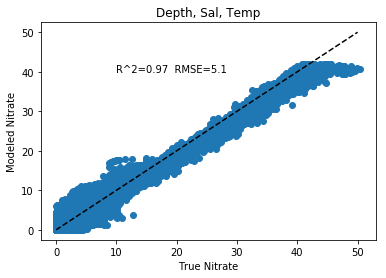

In [13]:
fig1 = plt.figure()
plt.scatter(true_nitrate,y_pred1_pos)
plt.xlabel('True Nitrate')
plt.ylabel('Modeled Nitrate')
plt.title('Depth, Sal, Temp')
b = np.linspace(0,50,50)
a = b
plt.plot(a,b,'--', color='k')
plt.text(10,40,'R^2=0.97  RMSE=5.1')
plt.show()
#fig1.savefig('depth_sal_temp.png', dpi = 300)

k = np.array(true_nitrate_pos)
j = np.array(y_pred1_pos)
diff = 100*np.abs((k-j)/k)
plt.scatter(k,diff)
plt.ylim([0,100])
plt.title('Depth, Sal, Temp')
plt.show()